# Setup

In [4]:
!source /etc/profile.d/modules.sh
!module load CUDA/11.2
!export PATH=/local/java/cuda-11.2/bin:$PATH
!export LD_LIBRARY_PATH=/local/java/cuda-11.2/lib64:/local/java/cudnn-8.1_for_cuda_11.2/lib64:$LD_LIBRARY_PATH  # this line is needed for it to recognise gpu devices -- run this in the terminal
!export CUDA_HOME=/local/java/cuda-11.2
import os 
import tensorflow as tf
import numpy as np
import random
import cv2
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
from datetime import datetime
from keras import backend as K

print(tf.__version__)  # 2.10.0
print(tf.config.list_physical_devices('GPU'))  # should show gpu available


2025-02-11 17:57:00.329200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 17:57:00.417205: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 17:57:00.440254: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 17:57:01.901113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-02-11 17:57:05.994458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-11 17:57:06.003135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-11 17:57:06.003240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Preprocess the images

In [5]:
def preprocess(image_path):
    # read the file 
    raw = tf.io.read_file(image_path)
    img = tf.io.decode_image(raw, expand_animations=False, channels = 3)
    img = tf.image.resize(img, size = (224, 224), preserve_aspect_ratio=True)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    img = tf.cast(img, tf.float32)/255.0
    return img 

def preprocess_pair(pair):
    imgA = preprocess(pair[0])
    imgB = preprocess(pair[1])
    return (imgA, imgB)

class RandomInvert(tf.keras.layers.Layer):
    def __init__(self, max_value = 255, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
        self.max_value = max_value

    def call(self, x):
        if  tf.random.uniform([]) < self.factor:
            x = (self.max_value - x)
        return x

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation((-0.4, 0.4)),
    tf.keras.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0., 1.)),
    tf.keras.layers.GaussianNoise(0.005),
    tf.keras.layers.RandomContrast(factor=(0.1, 0.9)),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

2025-02-11 17:57:06.014174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 17:57:06.014853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-11 17:57:06.014997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-11 17:57:06.015057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

# Hyper parameters

In [6]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATION = 2
MARGIN = 1.0

# Build the training and validation dataset

In [7]:
from read_data import read_data
from read_custom_data import read_custom_data
training_pairs, training_pairs_labels, validation_pairs, validation_pairs_labels = read_data()

In [8]:
def build_training_dataset():

    pairs_tensor = tf.convert_to_tensor(training_pairs)
    labels_tensor = tf.convert_to_tensor(training_pairs_labels)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (preprocess_pair(pair), label))
    result = result.shuffle(128, reshuffle_each_iteration=True)
    result = result.repeat()
    result = result.batch(BATCH_SIZE_TRAIN)
    result = result.map(lambda pair, y: ((data_augmentation(pair[0], training=True),data_augmentation(pair[1], training=True)), y), 
                num_parallel_calls=tf.data.AUTOTUNE)

    result = result.prefetch(tf.data.AUTOTUNE)

    return result

train_dataset = build_training_dataset()

def build_validation_dataset():

    pairs_tensor = tf.convert_to_tensor(validation_pairs)
    labels_tensor = tf.convert_to_tensor(validation_pairs_labels)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (preprocess_pair(pair), label))
    result = result.batch(BATCH_SIZE_VALIDATION)
    result = result.prefetch(tf.data.AUTOTUNE)

    return result

validation_dataset = build_validation_dataset()

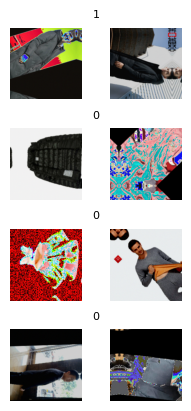

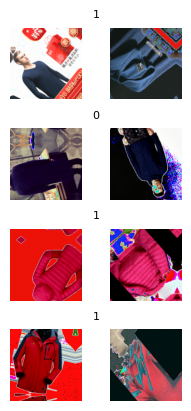

<Figure size 200x400 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, instances, batch_size, rows_per_image):

    img_size = 1

    fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
    subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
    subfigs = subfigs.flatten()
    row = 0
    for images, labels in dataset.take(instances):

        for i in range(batch_size):

            img_A = (images[0][i].numpy()*255).astype("uint8")
            img_B = (images[1][i].numpy()*255).astype("uint8")
            label = labels[i].numpy()

            axs = subfigs[row % rows_per_image].subplots(1, 2, sharey=True)

            axs[0].imshow(img_A)
            axs[0].axis("off")
            axs[1].imshow(img_B)
            axs[1].axis("off")

            subfigs[row % rows_per_image].suptitle(str(label), fontsize=8)
            row += 1
            if row % rows_per_image == 0:
                fig
                fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
                subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
                subfigs = subfigs.flatten()

visualize_dataset(train_dataset, 1, BATCH_SIZE_TRAIN, 4)

# Calculate euclidean distance

In [10]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_squared = K.sum(K.square(x-y), axis = 1, keepdims= True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Make embedding
embedding is each sub, identical model

In [11]:
def make_embedding():
    inputs = tf.keras.layers.Input(INPUT_SHAPE)
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    
    base_model.trainable = True
    limit = len(base_model.layers)-int(len(base_model.layers)*.10)
    for layer in base_model.layers[:limit]:
        layer.trainable =  False
          
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs=tf.keras.layers.Dense(64)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model
    

# Build siamese model

In [12]:
def make_siamese_model():
    # create embedding
    embedding = make_embedding()

    # create the same embedding for the two inputs 
    input_a = Input(shape = INPUT_SHAPE, name = "first_image")
    input_b = Input(shape = INPUT_SHAPE, name = "second_image")

    embedding_a = embedding(input_a)
    embedding_b = embedding(input_b)

    # Create the final euclidean distance layer
    output = Lambda(euclidean_distance, name = "distance")([embedding_a, embedding_b])

    return Model([input_a, input_b], output)

In [13]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 second_image (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 64)           2339968     ['first_image[0][0]',            
                                                                  'second_image[0][0]']     

# Contrastive loss function

In [14]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(MARGIN - y_pred, 0))
    return (y_true * square_pred + (1 - y_true) * margin_square)

# Set up precision and recall

In [15]:
class Custom_Precision(tf.keras.metrics.Precision):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)
  
class Custom_Recall(tf.keras.metrics.Recall):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)
  
class Custom_Accuracy(tf.keras.metrics.Accuracy):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)

# Compile and train model

In [16]:
EPOCHS = 15
model_file = "weights/best_fit.hdf5"
log_dir = "logs_new"

siamese_model.compile(loss=contrastive_loss, 
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=[Custom_Accuracy(), Custom_Precision(), Custom_Recall()]
                      )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 30, restore_best_weights = False)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

history = siamese_model.fit(train_dataset, 
                            steps_per_epoch=math.ceil(len(training_pairs) / BATCH_SIZE_TRAIN), 
                            # validation_data=validation_dataset, 
                            epochs = EPOCHS,
                            callbacks=[early_stop, checkpoint, tensorboard_callback])

Epoch 1/15


2025-02-11 17:57:16.486965: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-02-11 17:57:16.871606: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-11 17:57:16.872084: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-11 17:57:16.872099: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-02-11 17:57:16.872568: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-11 17:57:16.872594: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  1/529 [..............................] - ETA: 31:03 - loss: 33.6133 - accuracy: 0.2500 - custom__precision: 0.0000e+00 - custom__recall: 0.0000e+00

2025-02-11 17:57:17.137356: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


161/529 [========>.....................] - ETA: 8s - loss: 1.0440 - accuracy: 0.5893 - custom__precision: 0.6872 - custom__recall: 0.7257

KeyboardInterrupt: 

# Write model

In [ ]:
siamese_model.save("siameseModel.h5")

# Load model from .h5

In [18]:
test_model = load_model("siameseModel.h5", custom_objects={
    "contrastive_loss": contrastive_loss,
    "Custom_Precision": Custom_Precision,
    "Custom_Accuracy": Custom_Accuracy,
    "Custom_Recall": Custom_Recall
})

# Evaluate the model on validation data
Only the first 100 validation data are considered

In [ ]:
total = 0
correct = 0

for index, pair in enumerate(validation_pairs):
    imgA, imgB = preprocess_pair(pair)

    # Add batch dimension
    imgA = tf.expand_dims(imgA, axis=0)  # (1, 224, 224, 3)
    imgB = tf.expand_dims(imgB, axis=0)  # (1, 224, 224, 3)

    prediction = test_model.predict([imgA, imgB])  
    print(f"Distance: {prediction[0]}")
    print(f"Predicted: {prediction[0] <= 0.5}")
    print(f"Label: {bool(validation_pairs_labels[index])}")

    if (bool(validation_pairs_labels[index]) == (prediction[0] <= 0.5)):
        correct += 1
    total += 1

    if (total == 100):
        break

print(total)
print(correct)
print(f"Accuracy: {correct/total}")

# Evaluate on custom test data

In [ ]:
from read_custom_data import read_custom_data
custom_test_data = read_custom_data()

total = 0
correct = 0
print(custom_test_data)
for ia, ib, label in custom_test_data:
    pa = preprocess(ia)
    pb = preprocess(ib)

    # Add batch dimension
    imgA = tf.expand_dims(pa, axis=0)  # (1, 224, 224, 3)
    imgB = tf.expand_dims(pb, axis=0)  # (1, 224, 224, 3)

    prediction = test_model.predict([imgA, imgB])  
    print(f"Image 1: {ia}")
    print(f"Image 2: {ib}")
    print(f"Distance: {prediction[0]}")
    print(f"Predicted: {prediction[0] <= 0.5}")
    print(f"Label: {bool(label)}")

    if (bool(label) == (prediction[0] <= 0.5)):
        correct += 1
    total += 1

print(total)
print(correct)
print(f"Accuracy: {correct/total}")

In [24]:
from read_data import read_data
test = read_data(10100, 10300)
test_data, test_labels, _, _ = test

total = 0
correct = 0
for i in range(len(test_data)):
    ia = test_data[i][0]
    ib = test_data[i][1]
    label = test_labels[i]
    pa = preprocess(ia)
    pb = preprocess(ib)

    # Add batch dimension
    imgA = tf.expand_dims(pa, axis=0)  # (1, 224, 224, 3)
    imgB = tf.expand_dims(pb, axis=0)  # (1, 224, 224, 3)

    prediction = test_model.predict([imgA, imgB])  
    print(f"Image 1: {ia}")
    print(f"Image 2: {ib}")
    print(f"Distance: {prediction[0]}")
    print(f"Predicted: {prediction[0] <= 0.5}")
    print(f"Label: {bool(label)}")

    if (bool(label) == (prediction[0] <= 0.5)):
        correct += 1
    total += 1

    if (total == 100):
        break

print(total)
print(correct)
print(f"Accuracy: {correct/total}")

1/1 [==============================] - 0s 14ms/step
Image 1: products_10k/3307046.jpg
Image 2: products_10k/7915113.jpg
Distance: [0.43640727]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 14ms/step
Image 1: products_10k/3121086.jpg
Image 2: products_10k/5676644.jpg
Distance: [0.38849428]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 14ms/step
Image 1: products_10k/4151243.jpg
Image 2: products_10k/1715162.jpg
Distance: [0.39697233]
Predicted: [ True]
Label: False
1/1 [==============================] - 0s 14ms/step
Image 1: products_10k/7878445.jpg
Image 2: products_10k/5864905.jpg
Distance: [0.3573066]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 13ms/step
Image 1: products_10k/7438924.jpg
Image 2: products_10k/1909003.jpg
Distance: [0.5324406]
Predicted: [False]
Label: True
1/1 [==============================] - 0s 13ms/step
Image 1: products_10k/7637807.jpg
Image 2: products_10k/9676048.jpg
Distance: [